# Nested Transfer Learning Based for Expanded Datase

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
import matplotlib.pyplot as plt
tf.compat.v1.set_random_seed(0)
from tensorflow import keras
import numpy as np
np.random.seed(0)
import itertools
from keras.preprocessing.image import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import Rescaling, Resizing
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

In [ ]:
print(tf. __version__)

2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_gen = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseDataset/train")
test_gen = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseDataset/valid")


resize = Resizing(260,260)
train_gen = train_gen.map(lambda image,label:(resize(image),label))
test_gen  = test_gen.map(lambda image,label:(resize(image),label))

# rescale = Rescaling(scale=1.0/255)
# train_gen = train_gen.map(lambda image,label:(rescale(image),label))
# test_gen  = test_gen.map(lambda image,label:(rescale(image),label))

Found 41139 files belonging to 22 classes.
Found 10286 files belonging to 22 classes.


# **Training the model**

The model has been trained by splitting the epochs into three different sets.

In [ ]:
from tensorflow.keras.applications import EfficientNetB2
efficientnet = EfficientNetB2(weights=None, include_top=False, input_shape=(260, 260, 3)) 

In [ ]:
model_w = keras.models.load_model('/content/drive/MyDrive/pd_h5/pd_effnetb2_6.h5')

In [ ]:
model_w.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 flatten_1 (Flatten)         (None, 114048)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 114048)           456192    
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 114048)            0         
                                                                 
 batch_normalization_2 (Batc  (None, 114048)           456192    
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 114048)           

In [ ]:
model = keras.Sequential()


model.add(efficientnet)
# finetuning the layer
model.layers[0].set_weights(model_w.layers[0].get_weights())
# The layer is by default trainable


# # Add new layers
model.add(keras.layers.Flatten())
model.add(keras.layers.BatchNormalization())
model.layers[2].set_weights(model_w.layers[2].get_weights())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.BatchNormalization())
model.layers[4].set_weights(model_w.layers[4].get_weights())
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(22, activation='softmax'))

opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt,loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 9, 9, 1408)       7768569   
                                                                 
 flatten (Flatten)           (None, 114048)            0         
                                                                 
 batch_normalization (BatchN  (None, 114048)           456192    
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 114048)            0         
                                                                 
 batch_normalization_1 (Batc  (None, 114048)           456192    
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 114048)            0

In [ ]:
ep = 3
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep) 

Epoch 1/3
1286/1286 [==============================] - 5495s 4s/step - loss: 0.0981 - accuracy: 0.9715 - val_loss: 0.0189 - val_accuracy: 0.9950
Epoch 2/3
1286/1286 [==============================] - 939s 730ms/step - loss: 0.0306 - accuracy: 0.9912 - val_loss: 0.0262 - val_accuracy: 0.9947
Epoch 3/3
1286/1286 [==============================] - 940s 730ms/step - loss: 0.0353 - accuracy: 0.9918 - val_loss: 0.0434 - val_accuracy: 0.9924


In [ ]:
model.save('/content/drive/MyDrive/pd_h5/pdorft_efficientnetb2_3.h5')

In [ ]:
# Printing them just for using them later
print(history.history['loss'])
print(history.history['val_loss'])

print(history.history['accuracy'])
print(history.history['val_accuracy'])

[0.0981011614203453, 0.03055591508746147, 0.035323966294527054]
[0.018918132409453392, 0.02623455412685871, 0.0433632917702198]
[0.9715355038642883, 0.9911519289016724, 0.9918325543403625]
[0.9950417876243591, 0.9946529269218445, 0.9924168586730957]


# **4e - 4e**

In [ ]:
ep = 1
history = model.fit_generator(train_gen,
          validation_data=test_gen,
          epochs = ep) 

1286/1286 [==============================] - 935s 727ms/step - loss: 0.0351 - accuracy: 0.9931 - val_loss: 0.0582 - val_accuracy: 0.9919


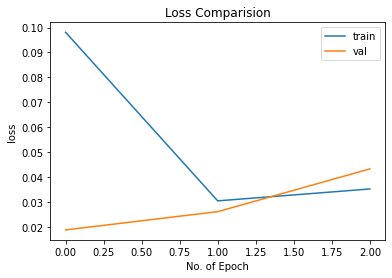

In [ ]:
# training and loss value
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Comparision')
plt.legend(['train','val'],loc='upper right')
plt.xlabel('No. of Epoch')
plt.ylabel('loss')
plt.show()

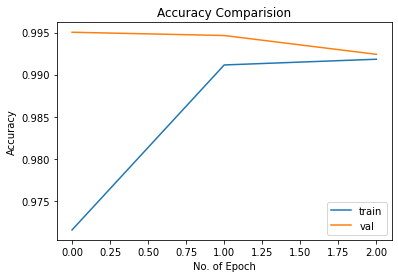

In [ ]:
# training and accuracy value
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Comparision')
plt.legend(['train','val'],loc='lower right')
plt.xlabel('No. of Epoch')
plt.ylabel('Accuracy')
plt.show()



# **Model Testing**

In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/pd_h5/pdorft_efficientnetb2_3.h5')

In [ ]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Train Accuracy  : {:.2f} %".format(history.history['accuracy'][-1]*100))
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Train Accuracy  : 99.18 %
Test Accuracy   : 99.24 %
Precision Score : 99.24 %
Recall Score    : 99.24 %


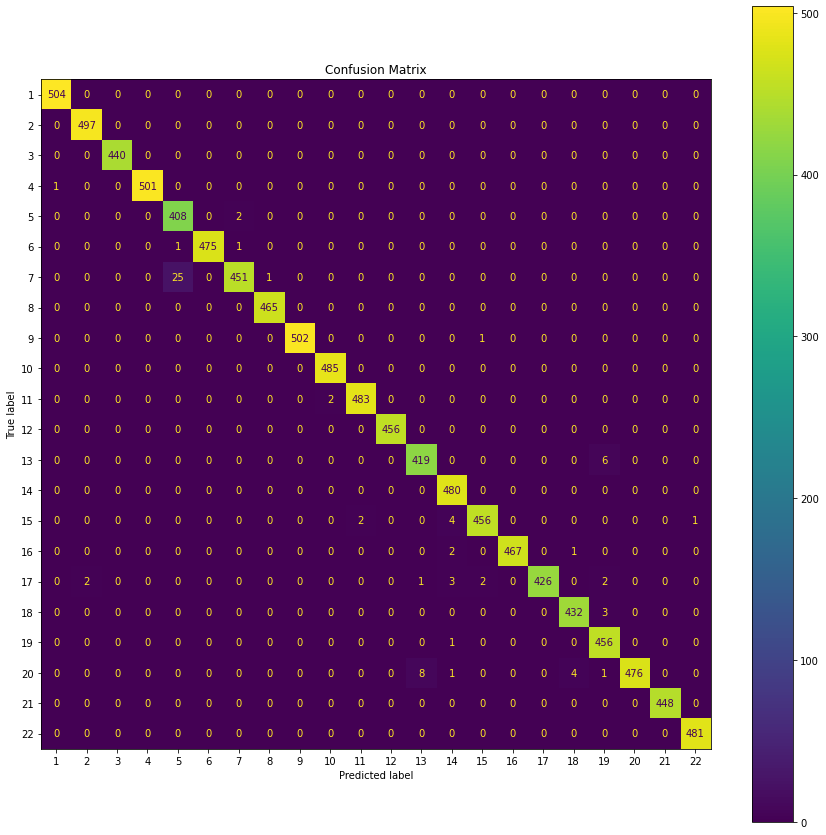

In [ ]:
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,23)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax)
plt.title("Confusion Matrix")
plt.show()

# **Model Testing with images unkown to the model**

In [ ]:

test_gen_act = image_dataset_from_directory(directory="/content/drive/MyDrive/PlantDiseaseDataset/test_act")

# rescale = Rescaling(scale=1.0/255)

# test_gen_act  = test_gen_act.map(lambda image,label:(rescale(image),label))

resize = Resizing(260,260)
test_gen_act  = test_gen_act.map(lambda image,label:(resize(image),label))

Found 38 files belonging to 22 classes.


In [ ]:
labels = []
predictions = []
for x,y in test_gen_act:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(model.predict(x),1).numpy())

In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

In [ ]:
print("Test Accuracy   : {:.2f} %".format(accuracy_score(labels, predictions) * 100))
print("Precision Score : {:.2f} %".format(precision_score(labels, predictions, average='micro') * 100))
print("Recall Score    : {:.2f} %".format(recall_score(labels, predictions, average='micro') * 100))

Test Accuracy   : 100.00 %
Precision Score : 100.00 %
Recall Score    : 100.00 %


In [ ]:
model = keras.models.load_model('/content/drive/MyDrive/pd_h5/pdorft_efficientnetb2_3.h5')

## Visualing Test Images Predictions

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import numpy as np
from skimage.color import rgba2rgb
from skimage import data


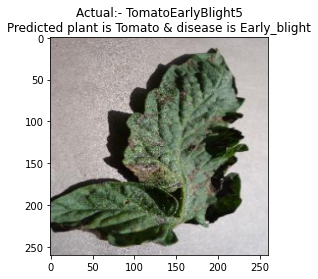

0 0



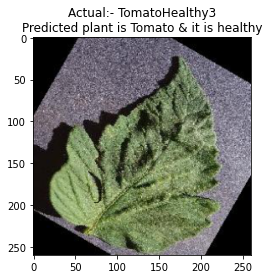

1 1



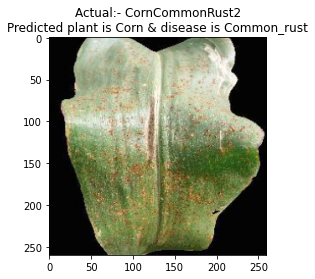

1 2



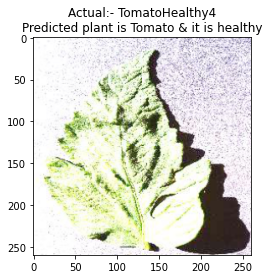

1 3



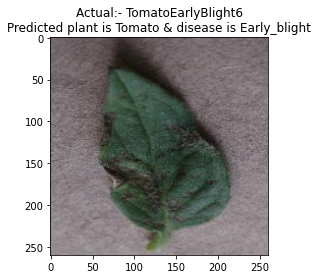

2 4



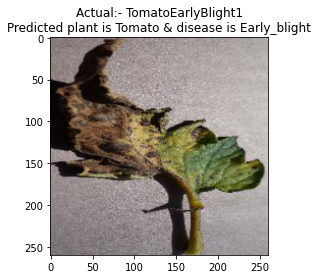

2 5



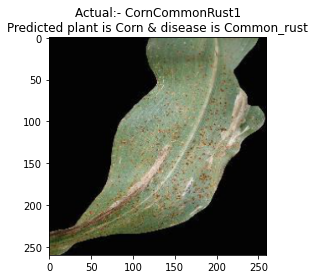

2 6



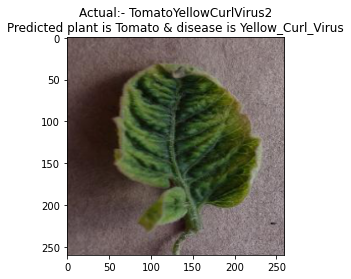

3 7



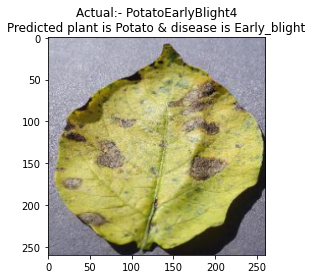

3 8



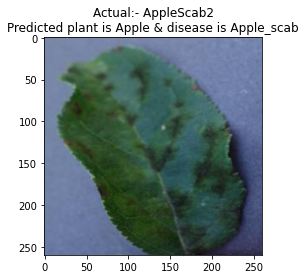

3 9



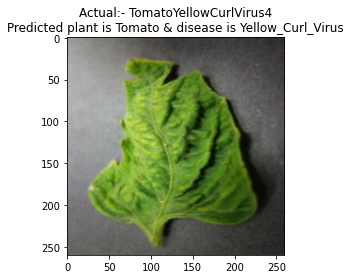

4 10



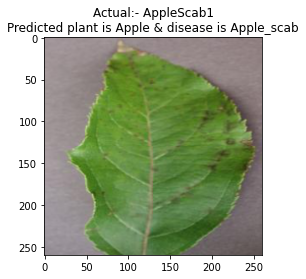

4 11



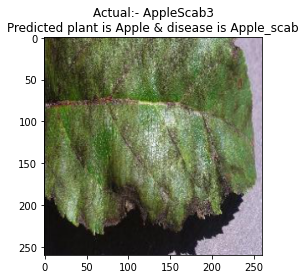

4 12



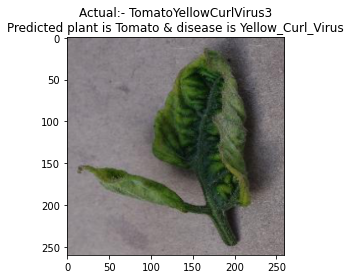

5 13



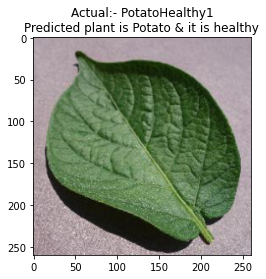

5 14



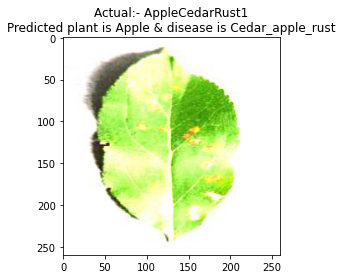

5 15



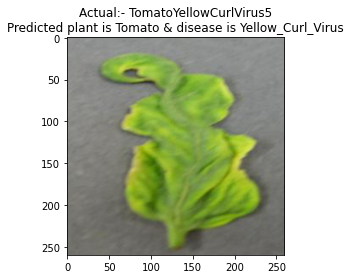

6 16



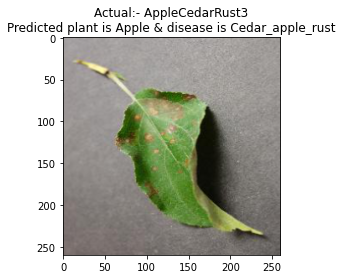

6 17



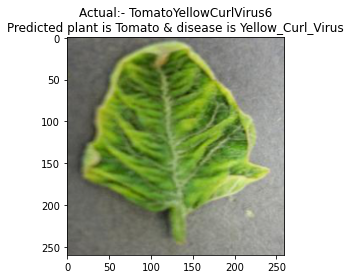

6 18



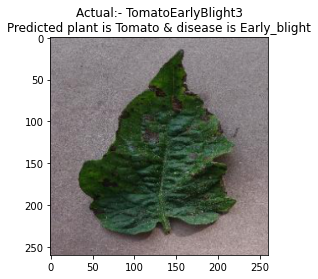

7 19



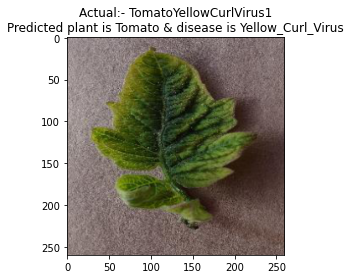

7 20



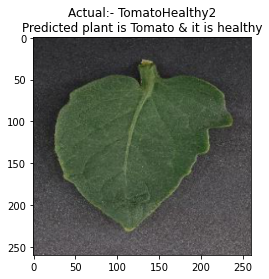

7 21



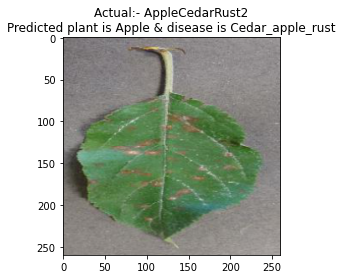

8 22



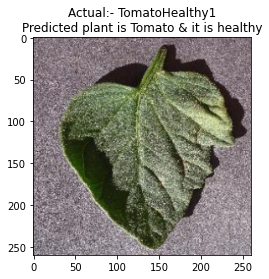

8 23



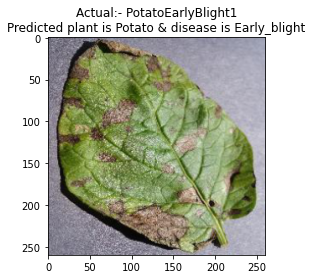

8 24



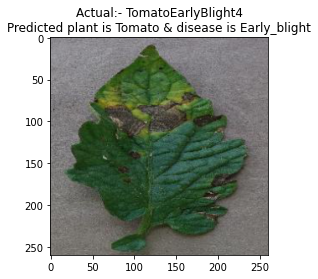

9 25



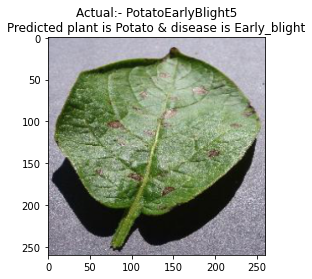

9 26



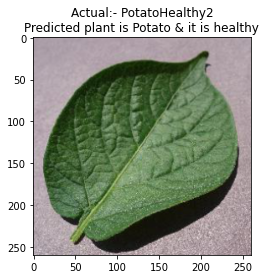

9 27



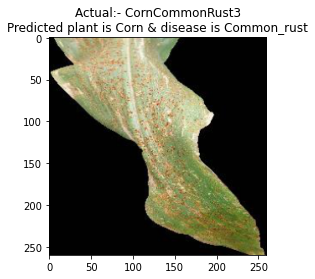

10 28



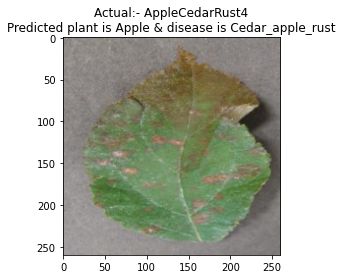

10 29



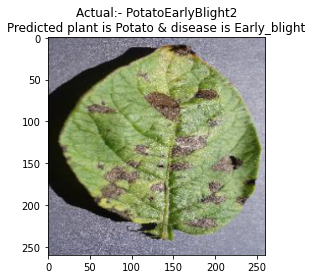

10 30



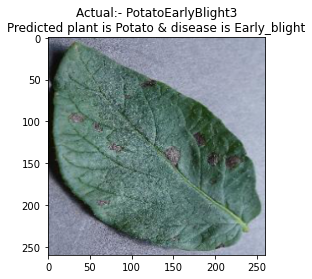

11 31



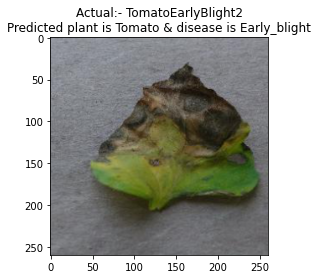

11 32



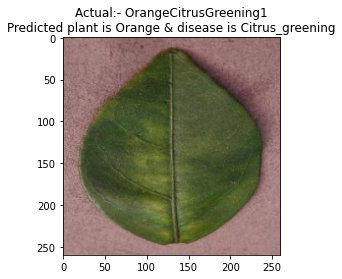

11 33



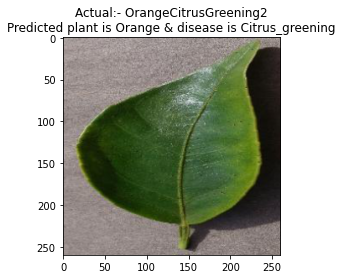

12 34



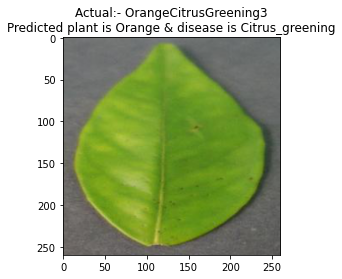

12 35



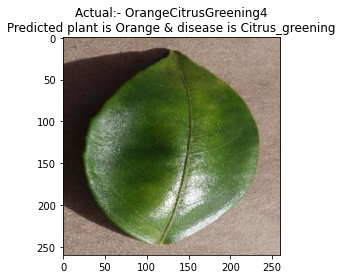

12 36



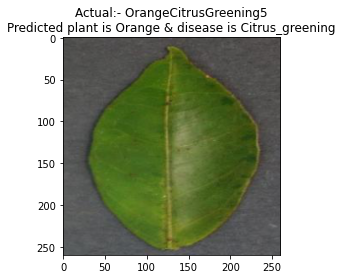

13 37


In [ ]:
# collecting names of images in the test folder
t_path = '/content/drive/MyDrive/PlantDiseaseDataset/test'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
from os import walk
t_img_names = next(walk(t_path), (None, None, []))[2]

n= len(t_img_names)
diseases=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
 'Corn___Gray_leaf_spot','Corn___Common_rust','Corn___Northern_Leaf_Blight','Corn___healthy',
 'Orange___Citrus_greening',
 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Yellow_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# fig, axs = plt.subplots(3, 3)
k=0
for i in range(n):
  # Read Image
  img = mpimg.imread(t_path+'/'+t_img_names[i])

  # bringing the image to format used for model training 
  if(img.shape[2]==4):
    img_rgb = rgba2rgb(img)
    # img = img[:,:,:3]

  img3 = cv2.resize(img,(260,260))
  
  img4 = np.reshape(img3,[1,260,260,3])
  
  # using the model to predict disease
  disease = np.argmax(model.predict(img4),axis=1)
  # disease is a list and at 0th index is the disease with highest probability 
  actual = 'Actual:- ' + t_img_names[i][:-4]
  # Splitting the predicted class to plant and disease name.
  plant, dis = diseases[disease[0]].split('___')
  if(dis.lower()=='healthy'):
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & it is "+dis
  else:
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & disease is "+dis
  # Setting up plt and showing the image used for prediction
  plt.title(finalAnnot)
  plt.imshow(img3)
  plt.show()
  print(k,i)
  if(i%3 == 0):
    k=k+1
  if(i!=(n-1)):
    print('')

## Model Testing with images taken by smartphone during this research.

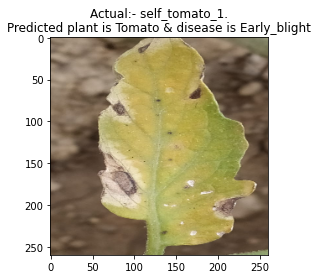

0 0



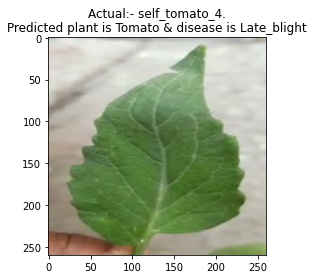

1 1



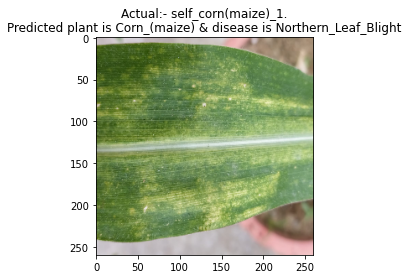

1 2



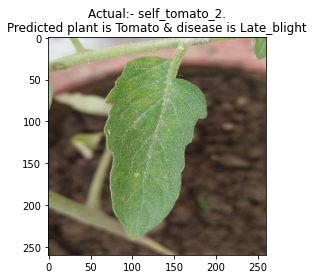

1 3



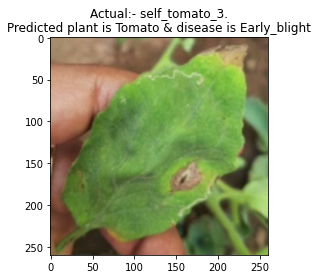

2 4



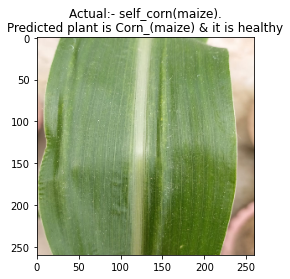

2 5



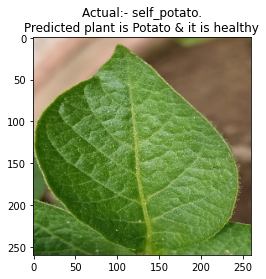

2 6


In [ ]:
# collecting names of images in the self tests folder
t_path = '/content/drive/MyDrive/PlantDiseaseDataset/self_tests'
from os import listdir
from os.path import isfile, join
onlyfiles = [f for f in listdir(t_path) if isfile(join(t_path, f))]
from os import walk
t_img_names = next(walk(t_path), (None, None, []))[2]

n= len(t_img_names)
diseases=['Apple___Apple_scab','Apple___Black_rot','Apple___Cedar_apple_rust','Apple___healthy',
 'Corn_(maize)___Gray_leaf_spot','Corn_(maize)___Common_rust','Corn_(maize)___Northern_Leaf_Blight','Corn_(maize)___healthy',
 'Orange___Citrus_greening',
 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

# fig, axs = plt.subplots(3, 3)
k=0
for i in range(n):
  # Read Image
  img = mpimg.imread(t_path+'/'+t_img_names[i])

  # bringing the image to format used for model training 
  if(img.shape[2]==4):
    img_rgb = rgba2rgb(img)
    # img = img[:,:,:3]

  img3 = cv2.resize(img,(260,260))
  
  img4 = np.reshape(img3,[1,260,260,3])
  
  # using the model to predict disease
  disease = np.argmax(model.predict(img4),axis=1)
  # disease is a list and at 0th index is the disease with highest probability 
  actual = 'Actual:- ' + t_img_names[i][:-4]
  # Splitting the predicted class to plant and disease name.
  plant, dis = diseases[disease[0]].split('___')
  if(dis.lower()=='healthy'):
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & it is "+dis
  else:
    finalAnnot = actual + '\n'+"Predicted plant is "+plant+" & disease is "+dis
  # Setting up plt and showing the image used for prediction
  plt.title(finalAnnot)
  plt.imshow(img3)
  plt.show()
  print(k,i)
  if(i%3 == 0):
    k=k+1
  if(i!=(n-1)):
    print('')

# Converting h5 to tflite for mobile use

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/pd_h5/pd_densenet201_6.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("pd_tfl_dn_6.tflite", "wb").write(tflite_model)


INFO:tensorflow:Assets written to: /tmp/tmphmro9xu6/assets


82829488

***References***
<br>
1 https://github.com/spMohanty/PlantVillage-Dataset
<br>
2 https://keras.io/examples/vision/image_classification_efficientnet_fine_tuning/
<br>
3 https://github.com/Abhishek-st/Skin-Lesion-Analysis/tree/master/ipynb_architecture_training
<br>
4 https://www.tensorflow.org/tutorials/images/transfer_learning
